# Homework - Network Analysis
In this homework you are to compute some descriptive statistics of a large graph.

The first part of this notebook constructs the graph for your analysis -- **do not change the codes in this part**. The latter part consists of your <a href="#scrollTo=eHdAbCpQ-z1J">homework</a>.

The purpose of this homework is to familiarize you with Python syntax and methods. Hence, you are free to search the internet for hints and new ways to solve the problems herein.

*Regarding the graph:*<br>
*The data used in this homework is mainly obtained from http://www.manga109.org/en/, with a couple of additions.*<br>
*The similarity between two comics has been computed in a way similar to the earlier lab "Community Detection", but with dissimilarity scores between 0.5 and 1.*


---



##Test case name
*Do not change the name for this homework. Leave it as "manga109".*

In [0]:
name="manga109"

## Imports

In [2]:
# Install GCP modules

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

# Install NetworkX module

!pip3 install networkx

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

Setting up gir1.2-glib-2.0:amd64 (1.54.1-1) ...
Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up gnupg-agent (2.1.15-1ubuntu8.1) ...
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod 

In [0]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import os
from google.colab import files, auth

## Helper functions

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration, loss):
    plt.plot(iteration, loss)
    plt.show()
    
# Set use_gcp to False to download a file to your local harddisk
def backup(filename, use_gcp=True):
    if name == "trial" and use_gcp: # No backup for the trial
        print("File \"" + filename + "\" not backed up since this is a trial run")
        return
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy " + filename + " gs://harddisk-1/" + name + "/")
    else:
        files.download(filename)

# Set use_gcp to False to upload a file from your local harddisk
def restore(filename, use_gcp=True):
    if use_gcp:
        project_id = 'twitter-for-bigquery'
        auth.authenticate_user()
        os.system("gcloud config set project twitter-for-bigquery")
        os.system("gsutil copy gs://harddisk-1/" + name + "/" + filename + " .")
    else:
        if os.path.exists(filename):
            os.remove(filename)
        uploaded = files.upload()
    !ls -l {filename}

# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G

# Save graph for use in Gephi or pals
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(filename, 'w')
    if header:
        f.write("Source,Target\n")
    for i in range(sim.shape[0]):
        for j in range(i+1, sim.shape[1]):
            if sim[i,j] != 0:
                if labels == None:
                    f.write(str(i) + delim + str(j) + "\n")
                else:
                    f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()

##Configuration

In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']
    labels = None



---


## Build graph
Construct an adjacency matrix from the dissimilarity matrix, then use the adjacency matrix to build a networkx graph


In [6]:
# Load a saved copy of the dissimilarity matrix

simfilename = "_sim.tsv"
labelfilename = "_labels.csv"

restore(simfilename)

X = np.genfromtxt(simfilename, delimiter='\t', encoding='utf8', dtype=None)
label2idx = dict()
sim = np.ones((len(X), len(X)))
if os.path.exists(labelfilename):
    os.remove(labelfilename)
f = open(labelfilename, 'w')
for t in X:
    t0, t1, t2 = t
    if not t0 in label2idx:
        idx = len(label2idx)
        label2idx[t0] = idx
        f.write(str(idx) + "," + t0 + "\n")
    if not t1 in label2idx:
        idx = len(label2idx)
        label2idx[t1] = len(label2idx)
        f.write(str(idx) + "," + t1 + "\n")
    idx0 = label2idx[t0]
    idx1 = label2idx[t1]
    sim[idx0][idx1] = t2
    sim[idx1][idx0] = t2
f.close()
    
print("Restored {}x{} matrix".format(sim.shape[0], sim.shape[1]))

-rw-r--r-- 1 root root 269002 Jul 17 10:39 _sim.tsv
Restored 7260x7260 matrix


In [7]:
# Restore labels from saved "_labels.csv" file

restore("_labels.csv")

Config.labels = []
with open('_labels.csv') as f:
    for line in f:
        _, label = line.rstrip().split(",")
        Config.labels.append(label)

print("Loaded labels (" + str(len(Config.labels)) + " classes): ", end='')
print(Config.labels)

-rw-r--r-- 1 root root 2196 Jul 17 10:39 _labels.csv
Loaded labels (121 classes): ['AisazuNihaIrarenai', 'AkkeraKanjinchou', 'Akuhamu', 'AosugiruHaru', 'AppareKappore', 'Arisa', 'BakuretsuKungFuGirl', 'Belmondo', 'BEMADER_P', 'BlackJack', 'BokuHaSitatakaKun', 'Buddha', 'BurariTessenTorimonocho', 'ByebyeC-BOY', 'Count3DeKimeteAgeru', 'DareMoNeteWaNaranu', 'DollGun', 'Donburakokko', 'DualJustice', 'EienNoWith', 'EvaLady', 'EverydayOsakanaChan', 'GakuenNoise', 'GarakutayaManta', 'GinNoChimera', 'GOOD_KISS_Ver2', 'Hamlet', 'HanzaiKousyouninMinegishiEitarou', 'HaruichibanNoFukukoro', 'HarukaRefrain', 'HealingPlanet', 'HeiseiJimen', 'HighschoolKimengumi_vol01', 'HighschoolKimengumi_vol20', 'HinagikuKenzan', 'HisokaReturns', 'HyougeMono', 'JangiriPonpon', 'JijiBabaFight', 'Jin', 'Joouari', 'Jyovolley', 'KarappoHighschool', 'KatteNiKaizoEd', 'KatteNiKaizoSt', 'KimiHaBokuNoTaiyouDa', 'Kiseiju', 'KonnaBlackJackWaIyada', 'KoukouNoHitotachi', 'KuroidoGanka', 'KyokugenCyclone', 'LancelotFullThrottl

avg=0.90 min=0.50 max=0.97


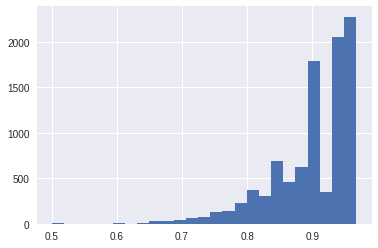

In [8]:
# Analyze distribution of dissimilarity score

simflat = sim.reshape((-1,))
simflat = simflat[simflat != 1] # Too many ones result in a bad histogram so we remove them
_ = plt.hist(simflat, bins=25)

mmax  = np.max(simflat)
mmin  = np.min(simflat)
mmean = np.mean(simflat)
print('avg={0:.2f} min={1:.2f} max={2:.2f}'.format(mmean, mmin, mmax))


In [9]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 0.82 # Do not change this value
adjmat = sim.copy()
np.fill_diagonal(adjmat, np.min(sim)) # Set the diagonal elements to a small value so that they won't be zeroed out
adjmat = adjmat.reshape((-1,))
adjmat[adjmat > threshold] = 0
#adjmat[adjmat > 0] = 1
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)

52699162 out of 52707600 values set to zero


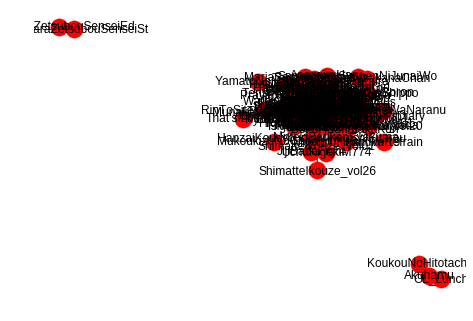

In [10]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)

G = make_graph(adjmat, labels=Config.labels)
nx.draw(G, with_labels=True)



---


##Community detection using Girvan-Newman

Possibility 1 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'OlympusNoBoron', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'EverydayOsakanaChan', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'JijiBabaFight', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 

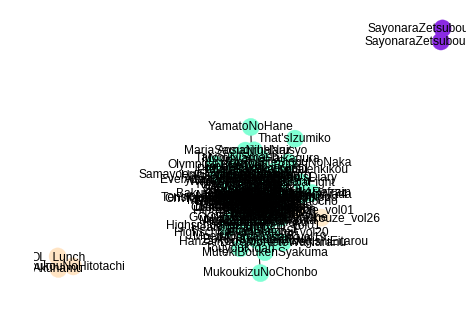

Possibility 2 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'OlympusNoBoron', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'EverydayOsakanaChan', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'JijiBabaFight', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 

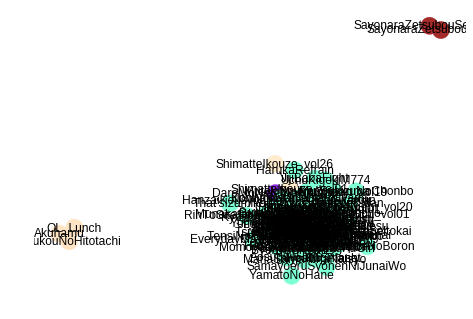

Possibility 3 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'OlympusNoBoron', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'JijiBabaFight', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC

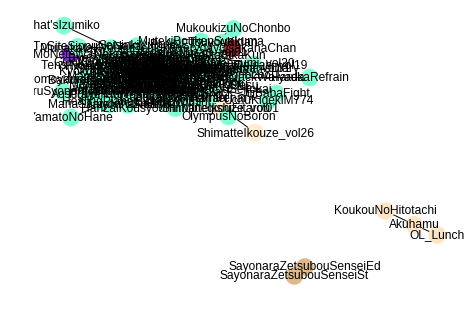

Possibility 4 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'OlympusNoBoron', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'Mukoukizu

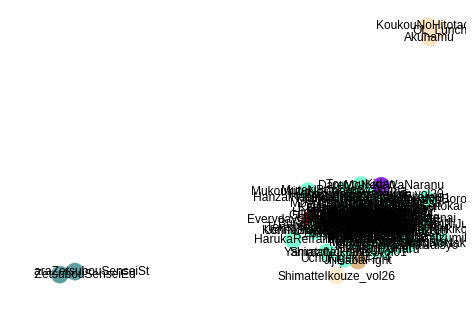

Possibility 5 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'OlympusNoBoron', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'Mukoukizu

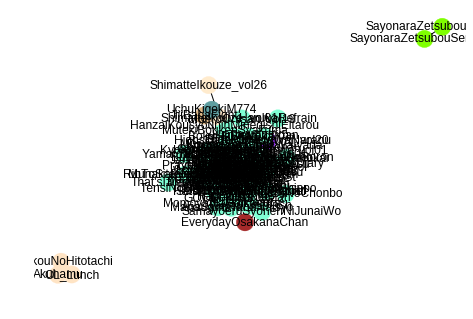

Possibility 6 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'MukoukizuNoChonbo', 'Syabon

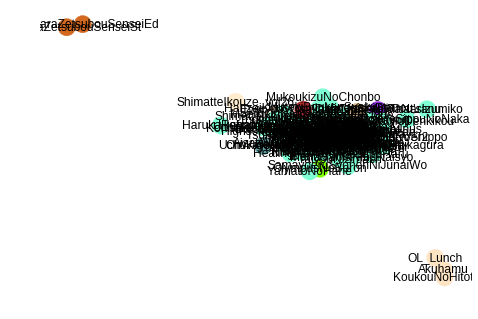

Possibility 7 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'YamatoNoHane', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'Kyokugen

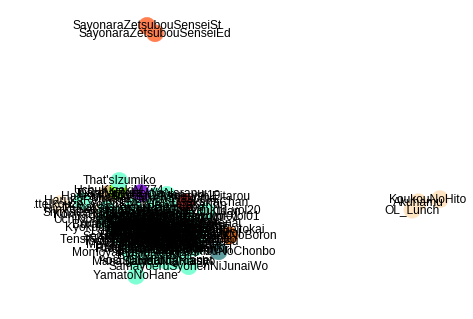

Possibility 8 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'KyokugenCyclone', 'Tenne

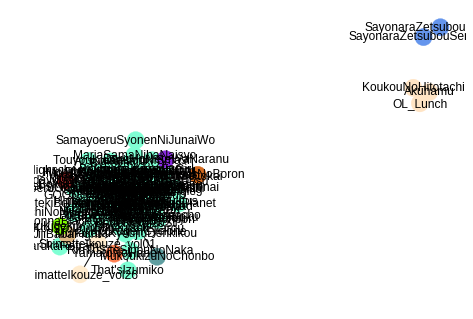

Possibility 9 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'KyokugenCyclone', 'Tenne

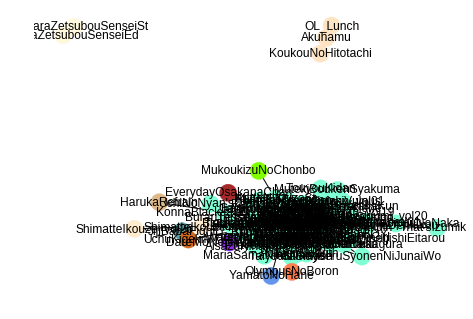

Possibility 10 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'TouyouKidan', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'KyokugenCyclone', 'Tenn

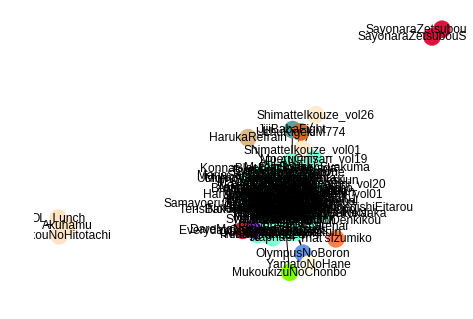

Possibility 11 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'KyokugenCyclone', 'TennenSenshiG', 'PL

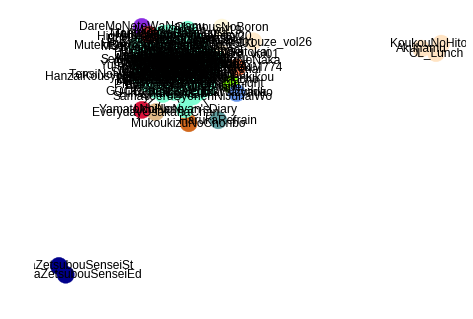

Possibility 12 : ({'ToutaMairimasu', 'TasogareTsushin', 'WarewareHaOniDearu', 'BokuHaSitatakaKun', 'KonnaBlackJackWaIyada', 'Buddha', 'YumeiroCooking', 'MunakataKyoujiuDenkikou', 'Donburakokko', 'AosugiruHaru', 'EienNoWith', 'LancelotFullThrottle', 'Ningyoushi', 'BEMADER_P', 'LoveHina_vol14', 'PlatinumJungle', 'Belmondo', 'ParaisoRoad', 'AppareKappore', 'PikaruGenkiDesu', 'YoumaKourin', 'GakuenNoise', 'HisokaReturns', 'TensiNoHaneToAkumaNoShippo', 'HinagikuKenzan', 'Count3DeKimeteAgeru', 'Arisa', 'BlackJack', 'RinToSiteSippuNoNaka', 'BurariTessenTorimonocho', 'YukiNoFuruMachi', 'HighschoolKimengumi_vol20', 'HighschoolKimengumi_vol01', 'KatteNiKaizoSt', 'GarakutayaManta', 'Kiseiju', 'AisazuNihaIrarenai', 'GOOD_KISS_Ver2', "UchiNoNyan'sDiary", 'GinNoChimera', 'MoeruOnisan_vol19', 'PrayerHaNemurenai', 'UnbalanceTokyo', 'MitsumeGaTooru', 'MemorySeijin', 'YasasiiAkuma', 'BakuretsuKungFuGirl', 'DollGun', 'PsychoStaff', 'ByebyeC-BOY', 'SyabondamaKieta', 'KyokugenCyclone', 'TennenSenshiG', 'PL

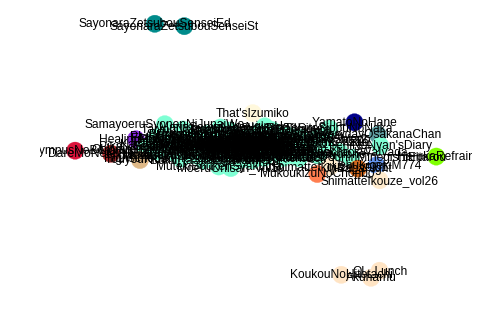

In [11]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 12
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possibility", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()

In [0]:
# Generate and download edges for Gephi

export_edge_list(adjmat, labels=Config.labels, filename='gephi-edges.csv')
backup('gephi-edges.csv', False)



---


##Homework
<a id="homework"></a>
Complete the questions below. The first question should be straightforward.

###Q1. Generate the edge file and community file for the pals system.




In [0]:
# Generate the community file for pals system

which_possibility = 3

communities = possibilities[which_possibility-1]

indices_in_community = []   # For obtaining submatrix of adjmat

f = open("pals-community.dat", 'w')
cur_com = 1
for c in communities:
    indices = [i for i, x in enumerate(Config.labels) if x in c]
    indices_in_community.extend(indices)
    for i in indices:
         f.write("\"" + Config.labels[i] + "\" " + str(cur_com) + "\r\n")
    cur_com += 1
f.close()

backup("pals-community.dat", False)


# Generate the graph file for pals system

# Obtain the submatrix of adjmat with only elements that appear in communities
indices_in_community = sorted(indices_in_community)
adjmat_in_community = adjmat[indices_in_community,:][:,indices_in_community]

# Obtain sublist of labels of only elements that appear in communities
labels = np.array(Config.labels)[indices_in_community].tolist()

export_edge_list(adjmat_in_community, labels=labels, filename='pals-edges.dat', delim=" ", header=False)

backup('pals-edges.dat', False)


###Q2. Find the node with the most number of neighbors

In [14]:
highestDegree = 0
for (node, val) in nx.degree(G):
  if(highestDegree < val):
    highestDegree = val
    highestNode = node
  
print(highestNode)

Arisa


### Q3. List the neighbors of the node (with the most neighbors) found above

In [15]:
neighbors = [n for n in G.neighbors(highestNode)]
print(neighbors)

['AppareKappore', 'BakuretsuKungFuGirl', 'Belmondo', 'BlackJack', 'Count3DeKimeteAgeru', 'DualJustice', 'EvaLady', 'GakuenNoise', 'GinNoChimera', 'GOOD_KISS_Ver2', 'HaruichibanNoFukukoro', 'HealingPlanet', 'HeiseiJimen', 'HinagikuKenzan', 'HisokaReturns', 'Jyovolley', 'KatteNiKaizoSt', 'Kiseiju', 'KuroidoGanka', 'LancelotFullThrottle', 'LoveHina_vol14', 'MAD_STONE', 'MadouTaiga', 'MagicStarGakuin', 'MemorySeijin', 'MeteoSanStrikeDesu', 'MisutenaideDaisy', 'MitsumeGaTooru', 'Nekodama', 'NichijouSoup', 'ParaisoRoad', 'PrayerHaNemurenai', 'PsychoStaff', 'Raphael', 'ReveryEarth', 'SaladDays_vol01', 'SaladDays_vol18', 'SonokiDeABC', 'SyabondamaKieta', 'TapkunNoTanteisitsu', 'TennenSenshiG', 'ToutaMairimasu', 'UltraEleven', 'YumeiroCooking']


###Q4. Plot a histogram of the degrees of the nodes in the graph






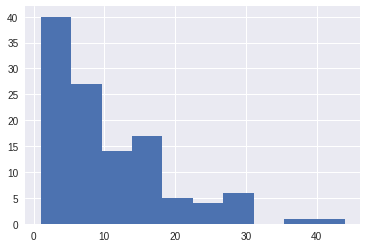

In [16]:
plt.hist(list(dict(nx.degree(G)).values()))
plt.show()

###Q5. Produce a list of the nodes sorted from that with the most neighbors to that with the least neighbors



In [60]:
degrees = [(node,val) for (node, val) in G.degree()]
s = sorted(degrees, key=lambda x: x[1], reverse=True)
print(s)

[('Arisa', 44), ('DualJustice', 36), ('SaladDays_vol18', 31), ('Donburakokko', 30), ('SaladDays_vol01', 30), ('Count3DeKimeteAgeru', 28), ('TennenSenshiG', 28), ('EvaLady', 27), ('ToutaMairimasu', 26), ('Jyovolley', 25), ('KuroidoGanka', 23), ('PsychoStaff', 23), ('AppareKappore', 22), ('LoveHina_vol01', 21), ('UnbalanceTokyo', 20), ('HeiseiJimen', 19), ('MitsumeGaTooru', 19), ('MAD_STONE', 18), ('HisokaReturns', 17), ('YoumaKourin', 17), ('SonokiDeABC', 17), ('LancelotFullThrottle', 17), ('MadouTaiga', 16), ('HaruichibanNoFukukoro', 16), ('UltraEleven', 16), ('AkkeraKanjinchou', 15), ('LoveHina_vol14', 15), ('TasogareTsushin', 15), ('WarewareHaOniDearu', 14), ('MeteoSanStrikeDesu', 14), ('ParaisoRoad', 14), ('TapkunNoTanteisitsu', 14), ('TensiNoHaneToAkumaNoShippo', 14), ('YukiNoFuruMachi', 14), ('YumeiroCooking', 12), ('MisutenaideDaisy', 12), ('SyabondamaKieta', 12), ('PlatinumJungle', 12), ('DollGun', 12), ('GakuenNoise', 11), ('GinNoChimera', 11), ('Belmondo', 11), ('BurariTessenT



---

##Submit homework (deadline Tuesday 11:59pm, 17 July 2018)

**IMPORTANT: Please follow the instructions below carefully.**

To submit this homework, go to the top menu and choose "**File**> **Download .ipynb**". This will save the document as a Jupyter notebook file.

You will find that the file has been saved with the name "**analyze_comics.ipynb**" (or "**Copy of analyze_comics.ipynb**", if its original name is "**Copy of analyze_comics.ipynb**").

Change the name of "**analyze_comics.ipynb**" to your student ID (e.g. **t0916001.ipynb**), and upload the file to IVLE in the folder "**Files**>  **Student Submission**> **Lab Homework**>" before the deadline.

**20% OF YOUR HOMEWORK MARKS WILL BE DEDUCTED IF YOUR FILENAME IS NOT YOUR STUDENT ID.**


